In [1]:
import numpy as np
import pandas as pd
import re
import os
from pandas.plotting import scatter_matrix

get_ipython().magic(u'env OMP_NUM_THREADS=2')

from IPython.display import display, HTML

%matplotlib inline
import matplotlib.pyplot as plt

#get_ipython().magic(u'matplotlib')
#get_ipython().magic(u'matplotlib inline')

# Set the ransom seed used for the whole program to allow reprocibility
np.random.seed(3214412)

from scipy.stats import pearsonr

from sklearn.feature_selection import f_regression, mutual_info_regression

env: OMP_NUM_THREADS=2


In [2]:
data_dir = '../data/processed'
feature_filename = os.path.join(data_dir, 'feature_set.csv')

In [3]:
feature_df = pd.read_csv(feature_filename)
feature_df.head()

,Survived,Sex,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Cabin_nan,Cabin_B,Cabin_C,Cabin_D,Cabin_E
0,0,1,7.2500,0,0,1,0,0,1,1,0,0,0,0
1,1,0,71.2833,1,0,0,1,0,0,0,0,1,0,0
2,1,0,7.9250,0,0,1,0,0,1,1,0,0,0,0
3,1,0,53.1000,1,0,0,0,0,1,0,0,1,0,0
4,0,1,8.0500,0,0,1,0,0,1,1,0,0,0,0


In [4]:
ind_df = feature_df.drop(labels='Survived', axis=1)
dep_df = feature_df.Survived

# Feature Selection

In [39]:
def sort_desc_print(tuple_list):
    s_list = sorted([(feature, score) for feature, score in tuple_list], key=lambda tup: tup[1], reverse=True)
    print('\n'.join(map(lambda v: v[0] + ': ' + str(v[1]), s_list)))

## Pearson Correlation

In [70]:
f_test, p_value = f_regression(ind_df, dep_df)
sort_desc_print(zip(ind_df.columns, f_test))

Sex: 372.405723602
Pclass_3: 103.057599394
Cabin_nan: 99.2531423426
Pclass_1: 79.1364033091
Fare: 63.030764228
Cabin_B: 28.1172283504
Embarked_C: 25.8959869956
Embarked_S: 22.0754685855
Cabin_D: 20.6631861322
Cabin_E: 20.6631861322
Cabin_C: 11.8416605341
Pclass_2: 7.8148047228
Embarked_Q: 0.0118463439904


## Mutual Information (MIC)

In [7]:
mi = mutual_info_regression(ind_df, dep_df)
mi /= np.max(mi)
sort_desc_print(zip(ind_df.columns, mi))

Sex: 1.0
Fare: 0.813183007255
Cabin_nan: 0.652875428308
Pclass_3: 0.306936307782
Pclass_1: 0.291382846285
Cabin_D: 0.239848945013
Cabin_C: 0.172495119254
Cabin_B: 0.14044352665
Pclass_2: 0.0661308728842
Cabin_E: 0.0403480347598
Embarked_Q: 0.0129620396289
Embarked_C: 0.0
Embarked_S: 0.0


/home/napoleon/.virtualenvs/kaggle_titanic/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


## Random Forests

In [8]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=1000, max_depth=100, n_jobs=4)
model.fit(ind_df, dep_df)
sort_desc_print(zip(ind_df.columns, model.feature_importances_))

Fare: 0.401696507844
Sex: 0.368575265298
Pclass_3: 0.100095863165
Cabin_nan: 0.0395412781757
Embarked_S: 0.0210514895722
Embarked_C: 0.0163977530968
Cabin_E: 0.0101863231028
Cabin_C: 0.00966006947128
Pclass_1: 0.00720195636071
Pclass_2: 0.00705191613979
Embarked_Q: 0.00697178649388
Cabin_D: 0.00590087636242
Cabin_B: 0.00566891491751


## Look for Collinearity

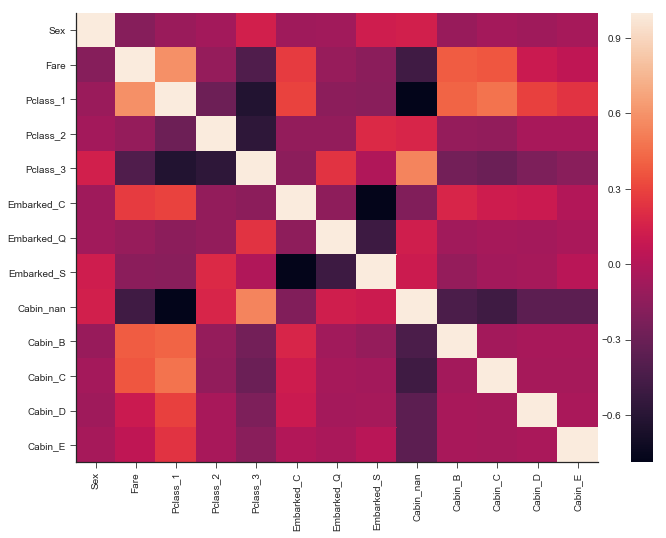

In [23]:
import seaborn as sns
%matplotlib inline

# calculate the correlation matrix
corr = ind_df.corr()

# plot the heatmap
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        ax=ax)
sns.despine()

In [28]:
corr_df = ind_df.corr()

In [67]:
import itertools
corr_tups = dict()

for colA, colB in itertools.product(corr_df.columns, corr_df.index):
    if colA == colB or (colA, colB) in corr_tups or (colB, colA) in corr_tups:
        continue
    corr_tups[(colA, colB)] = corr_df.loc[colA, colB]

sort_desc_print([(':'.join(key), val) for key, val in corr_tups.items() if abs(val) > 0.5])

Fare:Pclass_1: 0.591710718884
Pclass_3:Cabin_nan: 0.539290725364
Pclass_2:Pclass_3: -0.565210153554
Pclass_1:Pclass_3: -0.62673758464
Embarked_C:Embarked_S: -0.778358996113
Pclass_1:Cabin_nan: -0.788773006897


### Notes on Collinearity
* The Pclass_1 would cost a lot, so there would be a correlation between the Fare and the Pclass 1.
* The Pclass_3 passengers don't get cabins, so Cabin_nan is a logical correlation
* Can't be both Pclass_1 and Pclass_3, so these are obviously logically correllated.
* Pclass_1 and Cabin_nan are negatively correlated because if the passenger have a first class ticket, then obviously the passenger has an assigned cabin.

### Remove the following features
* Pclass_2
   * This feature is the only feature that has a high correlation with another feature, but does not score highly on the feature selection measurements.